# Single-cell Analysis of HCA data with Bioconductor 
In this Jupyter Notebook, we explore how to import HCA data and perform single-cell analysis (filtering, clustering, and differential gene expression) using [Bioconductor](https://www.bioconductor.org/), a suite of R tools for bioinformatic analysis. 

The tutorial is based off the Bioconductor tutorial ["Orchestrating Single-Cell Analysis with Bioconductor"](https://bioconductor.org/books/3.12/OSCA/index.html) (Amezquita et al., 2020). 

It uses subsampled human liver data (332,497 cells) from the HCA project ["Dissecting the human liver cellular landscape by single cell RNA-seq reveals novel intrahepatic monocyte/ macrophage populations"](https://data.humancellatlas.org/explore/projects/4d6f6c96-2a83-43d8-8fe1-0f53bffd4674).

Learn more about the data in "[Single cell RNA sequencing of human liver reveals distinct intrahepatic macrophage populations](https://www.nature.com/articles/s41467-018-06318-7)" (MacParland et al., 2018). 

Overall, the tutorial provides step-by-step instructions for:

- Importing and exploring HCA data files
- Filtering and visualizing cells based on QC metrics
- Normalizing single-cell data
- Identifying highly variable features (feature selection)
- Scaling and performing linear dimensional reduction
- Clustering cells
- Performing non-linear dimensional reduction
- Performing differential expression analysis

DISCLAIMER

This Notebook is designed to showcase Jupyter Notebook analysis of HCA data in Terra rather than teach single-cell analysis. The Biconductor tutorial has been modified to exclude some detailed information related to the highlighted bioconductor tools and analysis. To learn more about the features highlighted here, we encourage you to review the original [Bioconductor tutorial](https://bioconductor.org/books/3.12/OSCA/index.html).

## Notebook set-up

### Setting the Cloud Environment
This notebook uses the Terra R/Bioconductor base image (Python 3.7.9, R4.0.3) with 4 CPUs, which you can select from the Cloud Environment widget at the top right of the Workspace. 

**Important! Please note the compute requirements for this notebook:**
- Select 4 CPUs under the cloud compute profile in the Cloud Environment widget
- If you update the kernel after starting the notebook,delete the environment AND associated persistent disk before re-running the notebook

### Running the notebook
Prior to starting the notebook, we recommend restarting and clearing the kernel to remove outputs that were previously generated. This will help you understand what each code block is doing as the code is running. 

You can run the code blocks in this tutorial all at one time, or one-by-one. If you run each code block individually, make sure to run them in sequential order.

**Running all cells at one time**

To run all, select the "Cell" drop-down at the top of the notebook and choose "Run All".

**Running each cell individually**

You can run each cell individually in one of the following ways:
- Clicking the `Run` icon at the top of the notebook
- Using the shortcut shift return

## Installing notebook packages
The code below installs multiple Bioconductor and R packages (including the AnVIL package) that are useful for single-cell analysis.

#### What is the AnvIL package? 
The Bioconductor [AnVIL package](https://bioconductor.org/packages/release/bioc/html/AnVIL.html) is a suite of tools for working with Terra workspaces, data tables and external cloud resources, and includes utilities for movings files between cloud storage and the Terra Cloud Environment.

In [1]:
# Installing packages
install_if_missing <- function(packages) {
    packages_needed <- setdiff(packages, rownames(installed.packages()))
    if (length(packages_needed) > 0) { 
        BiocManager::install(packages_needed)
    }
}

packages_for_this_notebook <- c(
    "AnVIL",
    "LoomExperiment",
    "uwot",
    "PCAtools",
    "scater",
    "scran",
    "edgeR",
    "DropletUtils"
)

install_if_missing(packages_for_this_notebook)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.5 (2021-03-31)

Installing package(s) 'AnVIL', 'LoomExperiment', 'PCAtools', 'scater',
  'DropletUtils'

also installing the dependencies ‘beeswarm’, ‘vipor’, ‘R.oo’, ‘R.methodsS3’, ‘rapiclient’, ‘ggbeeswarm’, ‘viridis’, ‘R.utils’


Old packages: 'BiocManager', 'httpuv', 'IRkernel', 'rmarkdown', 'sass',
  'SeuratObject', 'statmod', 'stringi'



## Loading libraries
The code below installs the relevant libraries we need to run this notebook.

In [1]:
#Install libraries; suppressing start up messages to avoid a very long output
suppressPackageStartupMessages({
    library(AnVIL)
    library(LoomExperiment)
    library(scater)
    library(edgeR)
    library(scran)
    library(SingleCellExperiment)
    library(DropletUtils)
    library(uwot)
    library(PCAtools)
})

## Installing environment variables
The following code uses AnVIL functions to assign several environment variables that allow you to access and manipulate Terra featues like the workspace name, Google bucket, and Google billing project. 

In [2]:
# Assign environment variables and view them
project <- avworkspace_namespace()
workspace <- avworkspace()
bucket <- avbucket()
project
workspace
bucket

[1] "featured-workspaces-hca"

[1] "featured-workspaces-hca/Intro-to-HCA-data-on-Terra-notebook-dev"

[1] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0"

## Examine file details for the HCA project matrix
HCA and other consortia data files live in cloud storage, like Google buckets, Amazon Web Services, and Azure. Since files can live in diverse storage options, files are often given a cloud agnostic GA4GH-compliant identifier called a DRS URI (read more in this Terra Support [overview](https://support.terra.bio/hc/en-us/articles/360039330211)) 

- In this tutorial, we'll identify and move files between cloud environments using their DRS URIs. You can find an HCA data files DRS URI by looking for the DRS URI column in the  `participant` data table that Terra automatically creates when you import data. 



- For this tutorial's example project matrix (sc-landscape-human-liver-10XV2.loom), you'll find the DRS URI in the table's  `__loom__file_drs_uri` column. 



- The AnVIL package provides the `stats()` function as a useful way to look up files by DRS URIs and examine the the details before moving or manipulating it.



- Before using the function, we'll assign it to a variable (`drs_url`) so that we can reuse the variable with other functions later in the notebook. 


- The output below will show the file's name, size, date updated, and url for it's Google bucket location (in the gsURI column). 

In [3]:
# Look at DRS URI info for the 10x project matrix :`sc-landscape-human-liver-10XV2.loom`
drs_url <- 'drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c'
stats <- drs_stat(drs_url)
stats

fileName,size,contentType,gsUri,timeCreated,timeUpdated,bucket,name,googleServiceAccount,hashes
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<list>
sc-landscape-human-liver-10XV2.loom,1176122907,NA,gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,2021-02-19T19:31:35.668Z,2021-02-19T19:31:35.668Z,broad-datarepo-terra-prod-hca2-bucket,d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,NULL,"b01eb717 , 9b990461e64e4c35fa67e466c4a22cba"


## Importing HCA data into the Cloud Environment
The AnVIL package uses the `drs_cp()` function to copy and move files with a DRS URI. 

The code below will automatically import the file into our [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551) file location. 

In [5]:
# Copy file with DRS URI into Cloud Envrionemnt
drs_cp(drs_url, ".")

fileName,size,contentType,gsUri,timeCreated,timeUpdated,bucket,name,googleServiceAccount,hashes,simple,destination
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<list>,<lgl>,<chr>
sc-landscape-human-liver-10XV2.loom,1176122907,NA,gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,2021-02-19T19:31:35.668Z,2021-02-19T19:31:35.668Z,broad-datarepo-terra-prod-hca2-bucket,d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,NULL,"b01eb717 , 9b990461e64e4c35fa67e466c4a22cba",TRUE,./sc-landscape-human-liver-10XV2.loom


### Copying HCA data using gsutil
Since HCA data is stored in a Google bucket, we can also use Google's suite of tools for manipulating cloud data, [gsutil](https://cloud.google.com/storage/docs/gsutil). Forunately, the AnVIL package has gsutil built in. If you want to try it, just uncomment the code below. 

Same as above, this technique will automatically import the file into our [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551) file location. 

We used the `drs_stat()` function above to find the Google bucket URI, but you can also find this information in the `participant` data table. When you click the project matrix DRS URI link in the table's `__loom__file_drs_uri` column, you'll notice a new window with a gsutil command for copying the file from a Google bucket location, including the Google bucket URI. 

In [21]:
# home <- "/home/jupyter-user/notebooks/Intro-to-HCA-data-on-Terra-notebook-dev/edit"
# gs <- "gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom"
# gsutil_cp(gs, home)

Copying gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom...
/ [1/1 files][  1.1 GiB/  1.1 GiB] 100% Done  52.4 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.1 GiB.                                      

After importing the project matrix, we can confirm the import by listing files in our Cloud Environment's virtual machine. You should see the `sc-landscape-human-liver-10XV2.loom` file is now your Cloud Environment's file system.

In [7]:
# Confirm that `02f207ae-217b-42ce-9733-c03e61541fcc.loom` is in Cloud Environment disk
list.files()

[1] "Bioconductor_AnvIL.ipynb"            "Bioconductor.ipynb"                 
[3] "sc-landscape-human-liver-10XV2.loom" "Scanpy.ipynb"                       
[5] "Seurat (in-development).ipynb"       "Seurat.ipynb"

## Setting up SingleCellLoomExperiment object
Now that we have our matrix file in our Cloud Environment, we can start single-cell analyses. First, we'll need to make the matrix file format readable to Bioconductor. 

This tutorial's example project matrix was produced using the Optimus pipeline whose default count matrix output is a Loom file, an HDF5 file generated using [Loompy v.3.0.6](http://loompy.org/). Overall, the matrix contains UMI-corrected counts, global attributes, such as HCA metadata, and metrics for both individual cells (column attributes) and individual genes (row attributes).


Bioconductor tools often require a [SingleCellExperiment object](https://www.bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html), an S4 class for storing single-cell data. 

We'll convert the Loom to a SingleCellExperiment object using the [LoomExperiment](https://www.bioconductor.org/packages/release/bioc/html/LoomExperiment.html) class as an intermediatry between Loom files and SingleCellExperiment objects. 

When we look at the SingleCellLoomExperiment object (sce), we see it is a matrix with 58,347 genes and 332,497 unfiltered cells. 

In [8]:
# Import file as a SingleCellLoomExperiment and examine it
sce <- import("sc-landscape-human-liver-10XV2.loom", type="SingleCellLoomExperiment")
sce

class: SingleCellLoomExperiment 
dim: 58347 332497 
metadata(0):
assays(1): matrix
rownames: NULL
rowData names(29): Gene antisense_reads ... reads_per_molecule
  spliced_reads
colnames: NULL
colData names(43): CellID antisense_reads ... reads_unmapped
  spliced_reads
reducedDimNames(0):
altExpNames(0):
rowGraphs(0): NULL
colGraphs(0): NULL

### Exploring the Loom matrix attributes

HCA 10x data processed with the Optimus Pipeline has multiple cell and gene metrics that are uesful for downstream data filtering. The cell metrics are stored in the matrix colData (column data). 

The code below allows us to view the available cell metrics. Notice they include `emptydrops_IsCell` (measures if a cell is an empty droplet, as indicated by a 0), `pct_mitochondrial_molecules` (the percent of cell's mitochondrial molecules), and `n_genes` (the number of genes expressed in the cell). 

You can read more the Optimus metrics in the [Optimus Count Matrix Overview](https://broadinstitute.github.io/warp/documentation/Pipelines/Optimus_Pipeline/Loom_schema.html).  

In [9]:
# Review Column Data to see per cell metrics
colnames(colData(sce))

[1] "CellID"                                                
 [2] "antisense_reads"                                       
 [3] "cell_barcode_fraction_bases_above_30_mean"             
 [4] "cell_barcode_fraction_bases_above_30_variance"         
 [5] "cell_names"                                            
 [6] "duplicate_reads"                                       
 [7] "emptydrops_FDR"                                        
 [8] "emptydrops_IsCell"                                     
 [9] "emptydrops_Limited"                                    
[10] "emptydrops_LogProb"                                    
[11] "emptydrops_PValue"                                     
[12] "emptydrops_Total"                                      
[13] "fragments_per_molecule"                                
[14] "fragments_with_single_read_evidence"                   
[15] "genes_detected_multiple_observations"                  
[16] "genomic_read_quality_mean"                             
[17] "genomic_read_quality_variance"                         
[18] "genomic_reads_fraction_bases_quality_above_30_mean"    
[19] "genomic_reads_fraction_bases_quality_above_30_variance"
[20] "input_id"                                              
[21] "molecule_barcode_fraction_bases_above_30_mean"         
[22] "molecule_barcode_fraction_bases_above_30_variance"     
[23] "molecules_with_single_read_evidence"                   
[24] "n_fragments"                                           
[25] "n_genes"                                               
[26] "n_mitochondrial_genes"                                 
[27] "n_mitochondrial_molecules"                             
[28] "n_molecules"                                           
[29] "n_reads"                                               
[30] "noise_reads"                                           
[31] "pct_mitochondrial_molecules"                           
[32] "perfect_cell_barcodes"                                 
[33] "perfect_molecule_barcodes"                             
[34] "reads_mapped_exonic"                                   
[35] "reads_mapped_intergenic"                               
[36] "reads_mapped_intronic"                                 
[37] "reads_mapped_multiple"                                 
[38] "reads_mapped_too_many_loci"                            
[39] "reads_mapped_uniquely"                                 
[40] "reads_mapped_utr"                                      
[41] "reads_per_fragment"                                    
[42] "reads_unmapped"                                        
[43] "spliced_reads"

### Investigating the input_id
HCA project matrices contain a column attribute called `input_id`. This attribute contains IDs for the individual library preparations. For this tutorial's 10x dataset, each library preparation represents one donor.

In [10]:
# Examine the input_id, the IDs for library preparations
head(colData(sce)$input_id)

[1] "02f207ae-217b-42ce-9733-c03e61541fcc"
[2] "02f207ae-217b-42ce-9733-c03e61541fcc"
[3] "02f207ae-217b-42ce-9733-c03e61541fcc"
[4] "02f207ae-217b-42ce-9733-c03e61541fcc"
[5] "02f207ae-217b-42ce-9733-c03e61541fcc"
[6] "02f207ae-217b-42ce-9733-c03e61541fcc"

### Subsetting the matrix to one donor
For this tutorial, we're going to subset the project matrix to one donor (library preparation) using the matrix `input_id` column. This allows you to run the tutorial faster than using the whole matrix. 

You can also use the `input_id` to link data back to the HCA Metadata Manifest, which you can read more about in the Data Coordiation Platform's [Exploring Projects guide](https://data.humancellatlas.org/guides).

After subsetting, the matrix will contain 87,538 unfiltered cells.

In [11]:
# If we were using the project, matrix, we would only use first donor (library preparation) to downsample
donor1 <- sce$input_id == '02f207ae-217b-42ce-9733-c03e61541fcc'

In [12]:
# Assign the donor to column data
sce$donor <- donor1
summary(sce$donor)

   Mode   FALSE    TRUE 
logical  244959   87538 

In [13]:
# Only use donor 1
donor_filtered <- sce[,sce$donor]
# Reassign sce to donor_filtered
sce <- donor_filtered

### Renaming the matrix assay
If you look at the matrix above, you notice the assays field has one assay called `matrix`. We can rename the assay to be more meaningful to our data. Since Optimus output Loom files contain raw counts, let's call the assay `counts`.

In the output, you should now see a SingleCellLoomExperiment object with `assays(1):counts`.

In [14]:
# Rename assay to "counts"
assayNames(sce) <- "counts"
sce

# Explore the counts
# assay(sce, "counts")

class: SingleCellLoomExperiment 
dim: 58347 87538 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(29): Gene antisense_reads ... reads_per_molecule
  spliced_reads
colnames: NULL
colData names(44): CellID antisense_reads ... spliced_reads donor
reducedDimNames(0):
altExpNames(0):
rowGraphs(0): NULL
colGraphs(0): NULL

### Assigning gene_names to matrix row names
In the output above, the `rownames` are null. However, for downstream analysis, wee need the rownames to contain the gene names, so the code below reassigns the `gene_names` attribute to the rownames. The new SingleCellLoomExperiment object should have 58,347 gene names listed in the rownames field.

In [15]:
# Set the rownames to the gene_names
rownames(sce) <- rowData(sce)$gene_names
sce

class: SingleCellLoomExperiment 
dim: 58347 87538 
metadata(0):
assays(1): counts
rownames(58347): DDX11L1 WASH7P ... U6 U1
rowData names(29): Gene antisense_reads ... reads_per_molecule
  spliced_reads
colnames: NULL
colData names(44): CellID antisense_reads ... spliced_reads donor
reducedDimNames(0):
altExpNames(0):
rowGraphs(0): NULL
colGraphs(0): NULL

## Examining barcode ranks
Although the HCA Loom file contains emptydrops data in the cell metrics, we can examine the barcode ranks using [DropletUtils](https://bioconductor.org/packages/release/bioc/html/DropletUtils.html). The code below sets up and graphs a knee plot. To use this optional step, just uncomment the code blocks below.

In [16]:
# Uncomment below to explore empty droplets with knee plot using bcrank from DropletUtils; takes a few minutes
# bcrank <- barcodeRanks(counts(sce))

In [17]:
# Make a plot of the bar code ranks; only showing unique points for plotting speed.
# uniq <- !duplicated(bcrank$rank)
#plot(bcrank$rank[uniq], bcrank$total[uniq], log="xy",
#     xlab="Rank", ylab="Total UMI count", cex.lab=1.2)

#abline(h=metadata(bcrank)$inflection, col="darkgreen", lty=2)
#abline(h=metadata(bcrank)$knee, col="dodgerblue", lty=2)

#legend("bottomleft", legend=c("Inflection", "Knee"), 
#       col=c("darkgreen", "dodgerblue"), lty=2, cex=1.2)

We can also examine the existing emptydrops data using the `emptydrops_IsCell` metric. 

Notice the out put is `01` or `00`. Any cell that has a 01 is considered a cell, whereas a 00 is considered an empty lipid droplet. 

In [18]:
# Explore empty drops data from Optimus metrics
head(sce$emptydrops_IsCell)

[1] 01 01 01 01 01 01

## Filtering low-expressed genes
Next, let's filter for genes that are lowly expressed across cells. The [MacParland et al. (2018)](https://www.nature.com/articles/s41467-018-06318-7) publication removed genes if they were detected (UMI count > 0) in less than three cells. If we apply a similar filter, we create a matrix with 21,910 genes.

In [19]:
# Remove genes that have a UMI > 0 is more than 3 cells
keep_feature <- rowSums(counts(sce) > 0 ) > 3
table(keep_feature)

keep_feature
FALSE  TRUE 
36437 21910 

In [20]:
# Create a data frame with on the genes we want to keep
sce <- sce[keep_feature,]
sce

class: SingleCellLoomExperiment 
dim: 21910 87538 
metadata(0):
assays(1): counts
rownames(21910): AL627309.7 AL669831.3 ... AC007325.4 AC007325.2
rowData names(29): Gene antisense_reads ... reads_per_molecule
  spliced_reads
colnames: NULL
colData names(44): CellID antisense_reads ... spliced_reads donor
reducedDimNames(0):
altExpNames(0):
rowGraphs(0): NULL
colGraphs(0): NULL

The output above now shows that we only have 21,910 genes in our data frame. 

## Filtering for low-quality cells
There are multiple metrics that can identify low quality cells. We'll explore three of them: 
- library size (`lib_size`)
- the percent of mitochondrial molecules (`pct_mitochondrial_molecules`)
- Empty droplet data from Droplet Utils (`emptydrops_IsCell`)

We can calculate the library size (lib_size) by taking the total sum of counts across all relevant genes for each cell. 

In [21]:
# Calculate library size using counts, takes a few minutes
counts <- assay(sce, "counts")
lib_size <- colSums(counts)
lib_size
sce$sum <- lib_size

[1]  2508   272   403  5159  1945   270  1763  1053  9638   127  3132  3531
   [13]  4833  3783   250  3516  2102   183  4612  5048  1630   240  4164  4136
   [25]   127   222   304  1416   211   903   634  1643   449   314  5982  4310
   [37]  3094  3328  3656  5066   206   278  1649  3229  3034   191  5829   414
   [49]    93  1441  5354   502  2359   362  2252   190  6418   376  4562   282
   [61]  1965  1069   330  3534    86   235  3114   221  1343  5397   311   396
   [73]   228   378   379   588  3893   129  3762   144   667  2648   266   241
   [85]   193  1673  9745  2026   334   287  6318  1590  1696   172  1658   245
   [97]   263  5948  4129  2200  2747   785   171  4962  1775   264   270   147
  [109]   120  4304   307  3197  4600   613   457  4621   257   338   600   301
  [121]   141  6146   293  3293  3071  6880  5700   289  2163   152   375   144
  [133]  2528   160  5093   305   233   247  8606   191    78   173  3771   228
  [145]   224   352  2714   474   254  4965  3312   170   227   251  3242  4251
  [157]   186   538   193   341  2064   193   292    99  2939  5547   227  1581
  [169]   291   314   269  2243   256  9936   182   270   106   441   209   553
  [181]   242  4302   202  3635   159   401   391   156   261   438   237  6579
  [193]   460   192  1809  3631  2180   445   146    99  2049   296   257  4165
  [205]  1400  1466   209   494   135    93  1268   431   353  2273  3457  1578
  [217]   193   180  2321   435   315   166  4012   137   176   775   206   262
  [229]  1534  3649   309  1568   301  1674  3303  4900   232   367   464   442
  [241]   192  1785   273  5447   210   217   611   171   193  1356   230   354
  [253]   244   401  1279  1534  4628   535  4873  1171   284   919   277   235
  [265]   140   644  1977   227  2707   117   190   280  2033  3365   280  1149
  [277]   696   259   275   286   260   326   283   171   368   398   255   469
  [289]   205   362   276  4401  2108  4936   579   245  1541   486   334   235
  [301]    84   283   246   212   391   428  3165   144   267   384   214   205
  [313]   174   614  2123   124   212   257   235   318   171   246   292   293
  [325]   137   398   366   249   613  4470  4092   191   368   138   576  2264
  [337]   181  2842   447   473  3209   268   265   190   284   241   210   306
  [349]   450   280   207   161   397   149   156   171   835   190   589   126
  [361]   194   364   206   342   176   282   151   255   120   252   371   226
  [373]  4121   213   314   224    93  3590   279   120   278   263   302   493
  [385]   113   176   150   163   321   324   355   302  3030   200  2425   168
  [397]   175   197   215   199   193   325   252   353   511   193   199  1966
  [409]   198   257  1569   262   405   332   539   208   322   244   156   862
  [421]   353   240   282   195   471   151   229   202   197   259   209   266
  [433]   242   358   196   437   206   383  2309   239  1128   243   253   279
  [445]   335   136   722   289   359   514   264   288   243   302   166   167
  [457]  1499   294   422   334   401  1426   237  1248   208  1400  1158   326
  [469]   488   238   433   156   222   713   159   304   193   208   224   529
  [481]   142   244   312   245   246   605   297   256   202   179   214   289
  [493]   392   215   326   313   298   385   182   486   220   239   252   387
  [505]   168  1123   307   233   409   483  1645   264   300   332   246   125
  [517]  3235   282   192   488   270  1471   371   227   225   131   279   216
  [529]   240   321   195   240   240   313   237   261   213   218   533   368
  [541]   313   444  1257   321   241   232   102  1138   284   152   239   191
  [553]   635   182   225   106   401   216   194   129   137   175   390   171
  [565]   111   322  2576   384   274   339   351   285  1074   249   339   127
  [577]   188   104   289   218   473   332   245   262   453   300   158   190
  [589]   148   162   281   538   272    94    97   254   170   314   613   275
  [6

Next, we'll filter cells using common metrics already stored in the Loom column attributes. For all metrics, we can filter out low quality cells in two ways:
- manually defining thresholds
- defining thresholds with adaptive filtering

For this tutorial, we'll filter based on the criteria used in [MacParland et al. (2018)](https://www.nature.com/articles/s41467-018-06318-7) unless otherwise specified.

In the code block below, you'll see some manual thresholds you could use for filtering as well as some adaptive filters. To try any of the thresholds just uncomment the relevant code.

For the percent of mitochondrial molecules, we'll manually set a threshold whereby cells with more than 10% mitochondrial genes will be discarded. We'll also manually define the empty drops threshold. 

The optional adaptive filtering uses the `isOutlier()` function. See the [original Bioconductor tutorial](https://bioconductor.org/books/3.12/OSCA/index.html) for more details about adaptive filtering. 

After filtering, we can summarize the number of cells discarded in each filtering criteria. 

In [22]:
# Discard cells that meet manual thresholds
qc.lib2 <- sce$sum < 1.5e3
qc.empty <- sce$emptydrops_IsCell == 0

# For n_genes, publication keeps any cell with UMI counts > 0 in at least 3 cells but we could also use the n_genes metric to filter on cells that have a particular number of genes
# qc.nexprs2 <- sce$n_genes < 5e5

# Filtering for mitochondrial genes; original publication filtered on 50%; tutorial uses 10
qc.mito <- sce$pct_mitochondrial_molecules > 10

# Adaptive Filter Based on lib_size; original publication filtered genes with > 0 UMIs expressed in 3 cells
# qc.lib2 <- isOutlier(lib_size, log=TRUE, type="lower")
# qc.nexprs2 <- isOutlier(sce$n_genes, log=TRUE, type="lower")
# qc.mito <- isOutlier(sce$pct_mitochondrial_molecules, type="higher")

In [23]:
# Return the thresholds for adaptive filtering
# attr(qc.lib2, "thresholds")
# attr(qc.nexprs2, "thresholds")
# attr(qc.mito, "thresholds")
# summary(qc.empty)

In [24]:
# Discard reads that match outliers
# discard2 <- qc.lib2 | qc.nexprs2 | qc.empty | qc.mito
discard2 <- qc.lib2 | qc.empty | qc.mito

In [25]:
# Summarize the number of cells removed for each reason.
#DataFrame(LibSize=sum(qc.lib2), NExprs=sum(qc.nexprs2),
# empty=sum(qc.empty), mito=sum(qc.mito), Total=sum(discard2))

DataFrame(LibSize=sum(qc.lib2),
 empty=sum(qc.empty), mito=sum(qc.mito), Total=sum(discard2))


DataFrame with 1 row and 4 columns
    LibSize     empty      mito     Total
  <integer> <integer> <integer> <integer>
1     81588     46766     84948     85946

The data frame above shows that we removed 81,588 cells based on the library size, 46,766 cells based on the empty drops, and 84,948 cells based on the percent of mitochondrial genes. In total, 85,946 cells were filtered.

We can summarize this below and see that our filtered matrix for this one donor now contains 1,592 cells. 

In [26]:
# Adding discard2 to matrix as new column data ("discard")
sce$discard <- discard2
summary(sce$discard)

   Mode   FALSE    TRUE 
logical    1592   85946 

We can add the discarded criteria to a new column in the SingleCellExperiment class. We can then use that information for plotting QC graphs.

The output is two violin plots that show total library sums for all cells. The top graph is colored by mitochondrial cells that are discarded and the bottom graph is colored by cells discarded based on empty drops thresholds.  

In [27]:
sce$mito_discard <- qc.mito
# sce$nexprs2_discard <- qc.nexprs2
sce$empty_discard <- qc.empty

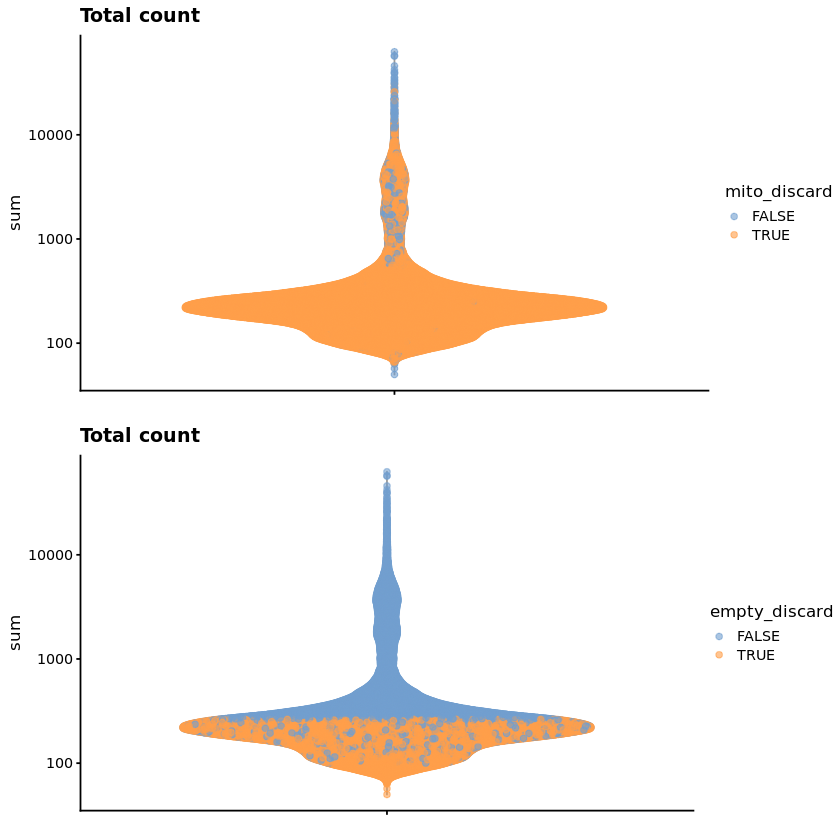

In [28]:
# Plot the library size and color by discarded vs kept for discard criteria
gridExtra::grid.arrange(
  plotColData(sce, y="sum", colour_by="mito_discard") + 
    scale_y_log10() + ggtitle("Total count"),
  plotColData(sce, y="sum", colour_by="empty_discard") + 
    scale_y_log10() + ggtitle("Total count"), 
  ncol=1
)

Lastly, let's create a new data frame with the low quality cells removed.

In [29]:
# Remove low-quality cells, runs fast
filtered <- sce[,!sce$discard]

## Normalizing the data
Normalization removes interferance from differences in library preparation, sequencing coverage, etc. 

This tutorial normalizes the data using pool-based size factors to overcome the dominance of low and zero counts in single-cell data ([Lun et al.,2016](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7)). 

First, we precluster the cells using the `quickCluster()` function; this normalizes cells in each cluster separately and rescales the size factors so they are comparable across clusters. 

Next, we use `computeSumfactors()` function to normalize by deconvolution and the `logNormCounts()` functon to normalize expression in each cell.


In [30]:
# Use functions from scran to normalize- pool counts from many cells; will return error if using small sample
# Preclustering with quickCluster(); cells in each cluster normalized separately 
set.seed(100)
clust.filtered <- quickCluster(filtered) 
# Examine a table of the clusters and numbers of cells in each cluster
table(clust.filtered)

# Calculate and Apply pool based size factors 
pool.filtered <- computeSumFactors(filtered, cluster=clust.filtered, min.mean=0.1)
norm.filtered <- logNormCounts(pool.filtered)

#Verify that the logcounts from normalization are in the data frame
assayNames(norm.filtered)


clust.filtered
  1   2   3   4   5   6   7   8 
213 233 287 203 211 152 159 134 

[1] "counts"    "logcounts"

## Identifying highly variable features
Identifying genes and other features that are highly variable from cell-to-cell can help highlight biological signal.

First, we'll use the `modelGenVar() function` to fit a variance trend with respect to gene abundance. Then we'll visualize the fit. 

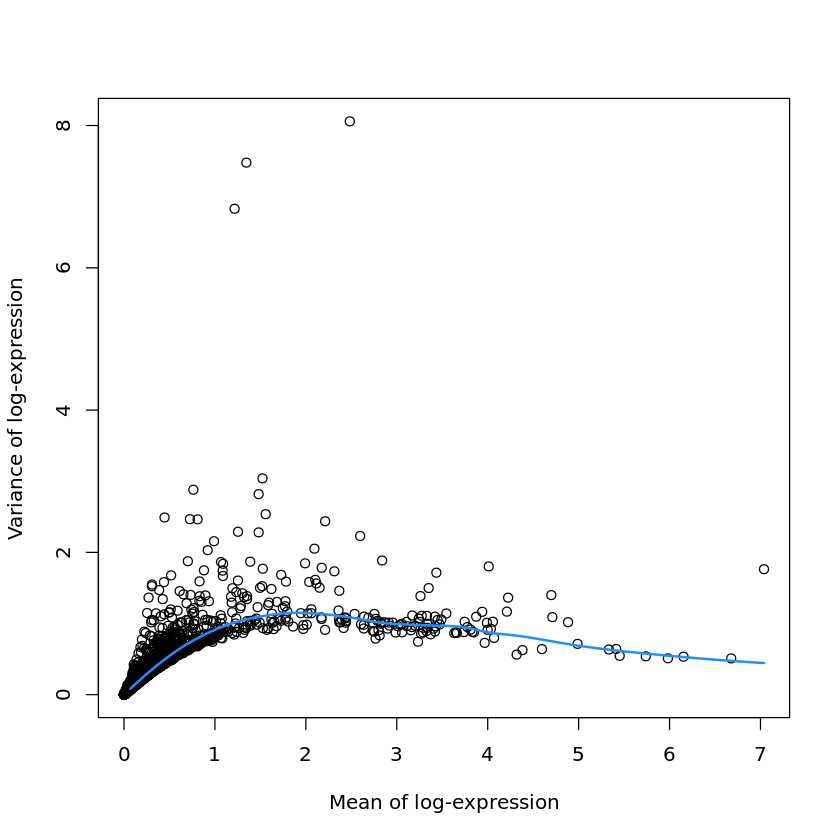

In [31]:
# Calcualate per gene variance
dec.filtered <- modelGeneVar(norm.filtered)

# Visualizing the fit:
fit.sce <- metadata(dec.filtered)
plot(fit.sce$mean, fit.sce$var, xlab="Mean of log-expression",
     ylab="Variance of log-expression")
curve(fit.sce$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In the output plot, each black dot is a cell and the blue line is the fitted trend.

Next, let's identify highly variable genes. We can calculate a PCA based on those highly expressed genes and save it in our data frame.

In [32]:
# Identify highly variables genes
hvgs.filtered <- getTopHVGs(dec.filtered, n = 1000)

## Performing dimensionality reduction

###  Principle Component Analysis (PCA)
PCA analysis helps us capture the dominant factors of heterogeneity in our dataset.
We’ll use the `RunPCA()` function (from [scran](https://bioconductor.org/packages/release/bioc/html/scran.html)) to perform PCA analysis on the highly variable genes we selected in the last section. 

The function will compute the first 50 PCs and store them in the reducedDims() of the output SingleCellExperiment object. 


In [33]:
# Run PCA on highly expressed genes and assign it to the data frame
norm.filtered <- runPCA(norm.filtered, subset_row=hvgs.filtered)

### Choosing PCs for downstream analysis
To identify PCs to use in downstream analysis, we can make a scree plot. This plots the percentage of variance explained by successive PCs. 

The “elbow” in the curve of a scree plot is the point where biological signal is likely no longer captured by the successive PCs. 


In [34]:
#Choosing PCs using scree plot
percent.var <- attr(reducedDim(norm.filtered), "percentVar")
chosen.elbow <- PCAtools::findElbowPoint(percent.var)
chosen.elbow

[1] 6

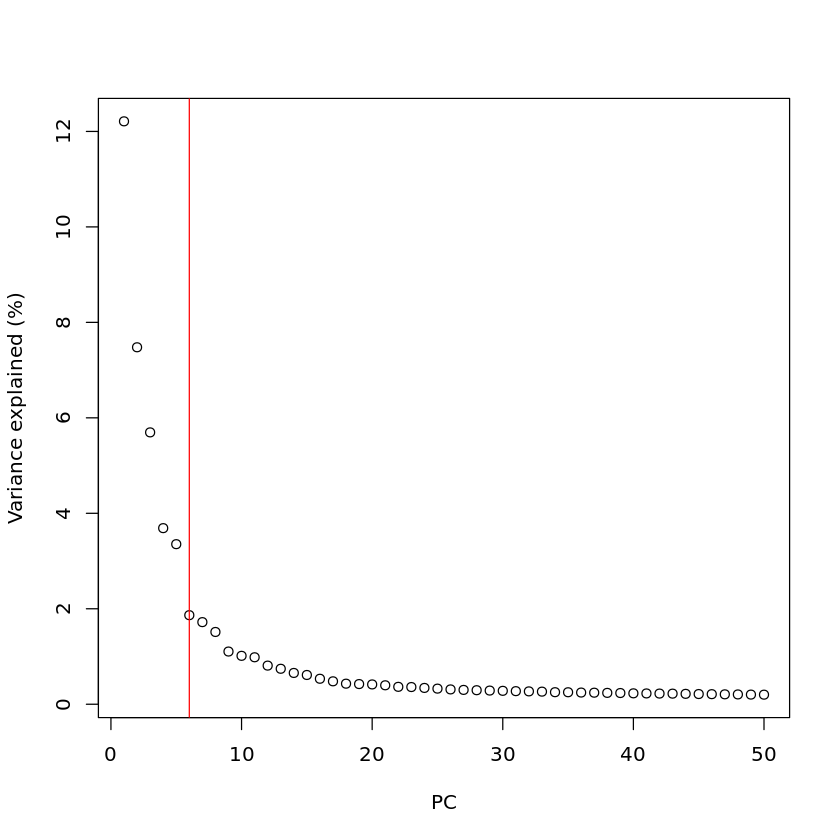

In [35]:
# Setting up scree plot with elbow
plot(percent.var, xlab="PC", ylab="Variance explained (%)")
abline(v=chosen.elbow, col="red")

In [36]:
# Add a new column SCE object using PCs from elbow plot
reducedDim(norm.filtered, "PCA.elbow") <- reducedDim(norm.filtered)[,1:chosen.elbow]
reducedDimNames(norm.filtered)

[1] "PCA"       "PCA.elbow"

### Performing non-linear dimensional reduction (t-SNE and UMAPs)
We can use the `RunTNSE()` and `RunUMAP()` functions to place similar cells together in low-dimensional space and produce a t-SNE and UMAP graph, respectively. However, note that the cells are not yet clustered.


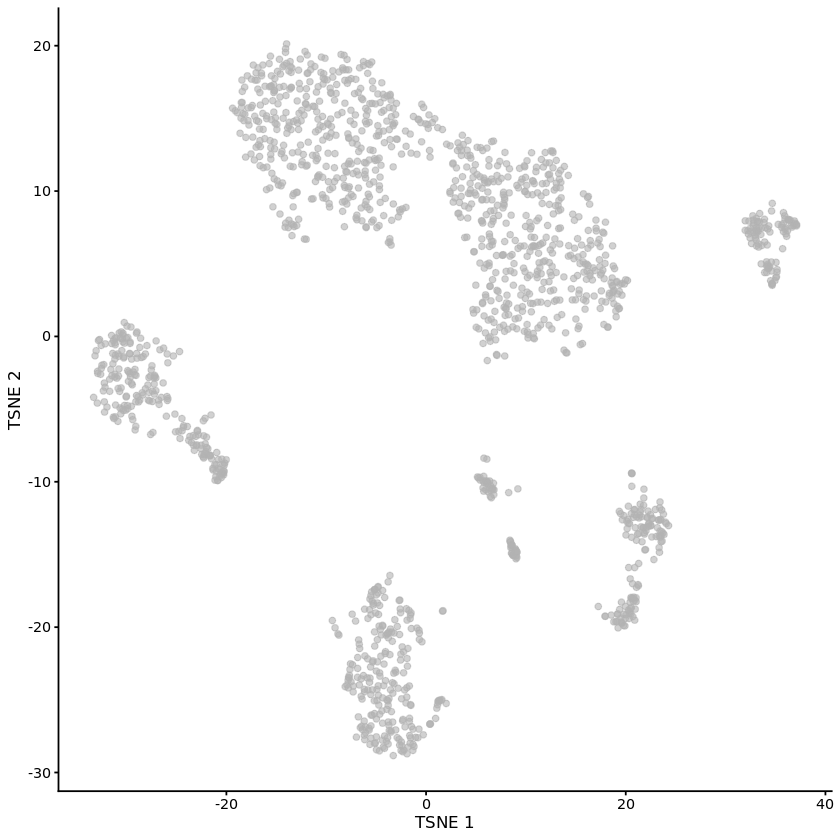

In [37]:
# Run t-sne
set.seed(00101001101)

# runTSNE() stores the t-SNE coordinates in the reducedDims
# for re-use across multiple plotReducedDim() calls.
norm.filtered <- runTSNE(norm.filtered, dimred="PCA.elbow")
plotReducedDim(norm.filtered, dimred="TSNE")

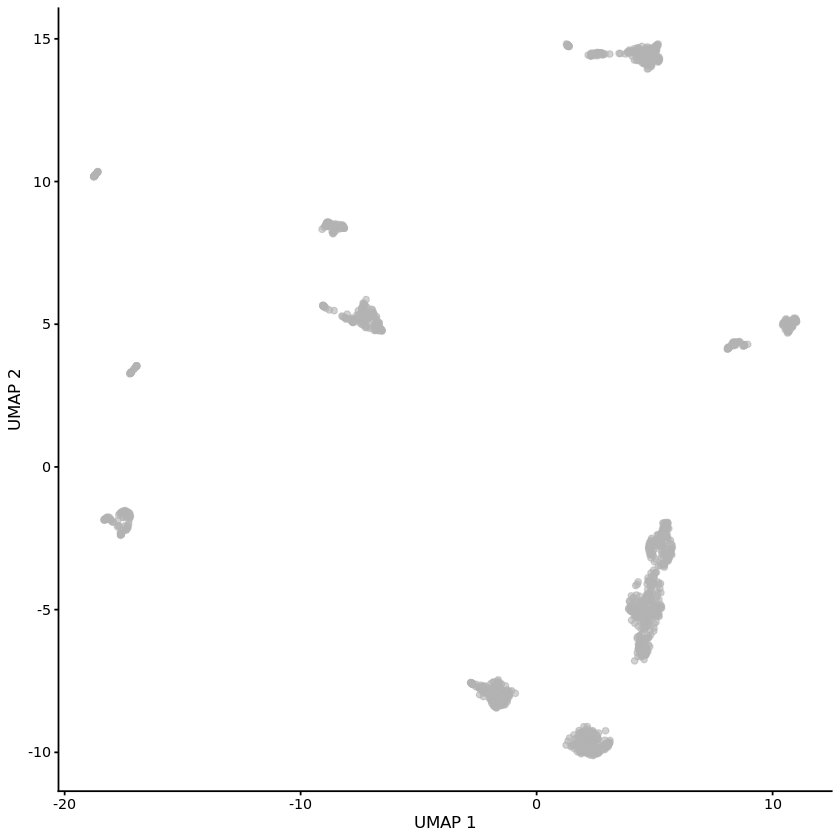

In [38]:
# Run UMAP
set.seed(1100101001)
norm.filtered <- runUMAP(norm.filtered, dimred="PCA")
plotReducedDim(norm.filtered, dimred="UMAP")

## Clustering cells
Clustering allows us to group together cells with similar gene expression patterns. While this doesn’t tell us the cell identity, it is a tool that can be used for downstream cell annotation. 

This tutorial has two options for clustering:
1. Graph-based clustering (implementation used by Seurat)
2. K-means clustering
 
The k-means clustering code is commented out by default; just uncomment the code to try it out. 


clust
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 
328 170 163 150 254  64 106  42  47  26  44  87  32  27  27  25 

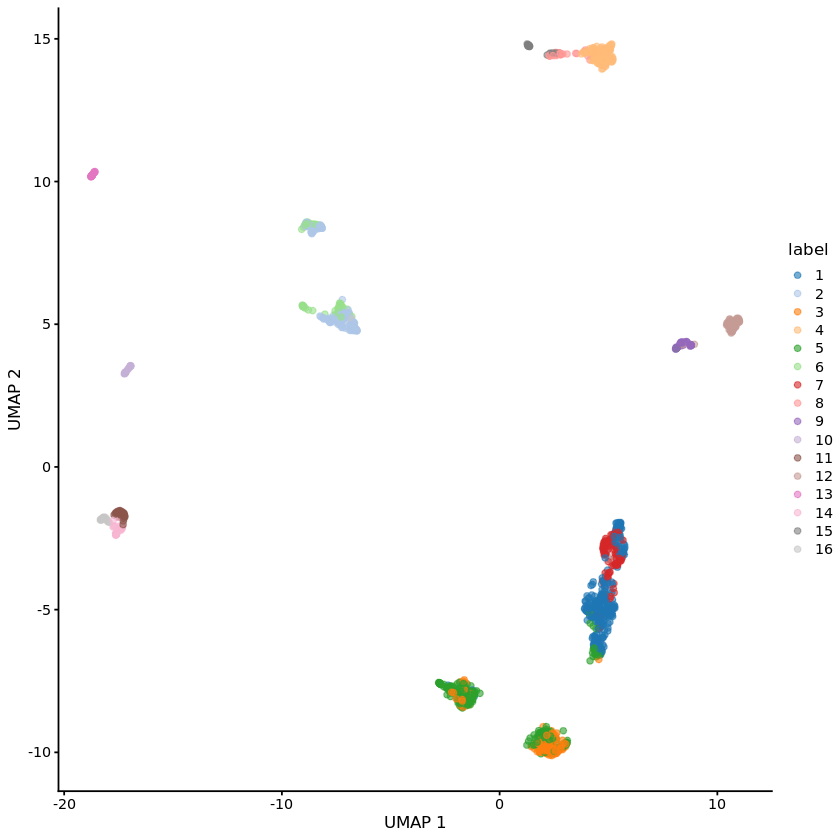

In [39]:
# Graph-based clustering with scran
g <- buildSNNGraph(norm.filtered, k=10, use.dimred = 'PCA.elbow')
clust <- igraph::cluster_walktrap(g)$membership
table(clust)

# Plotting of graph-based cluster with scater
# NOT IN PROD YET: colLabels(norm.filtered) <- factor(clust)
norm.filtered$label <- factor(clust)
plotReducedDim(norm.filtered, "UMAP", colour_by = "label")

In [40]:
# k-means clustering
# set.seed(100)
# clust.kmeans <- kmeans(reducedDim(norm.filtered, "PCA.elbow"), centers=14)
# table(clust.kmeans$cluster)

# Plotting k-means
# norm.filtered$label <- factor(clust.kmeans$cluster)
# plotReducedDim(norm.filtered, "UMAP", colour_by = "label")


## Differential gene expression testing
We want to identify marker genes that are differentially expressed for each cell cluster. To do this, we use the `find.Markers()` function from [scran](https://bioconductor.org/packages/release/bioc/html/scran.html). 

Then we can examine the most highly expressed genes in any one particular cluster (cluster 4 for this example) relative to each of the other clusters.

We'll then write the results to CSV file.

In [41]:
# T-test for differential expression between clusters
markers.sce <- findMarkers(norm.filtered)
markers.sce

List of length 16
names(16): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

In [42]:
# Choose one cluster to examine
chosen <- "4"
interesting <- markers.sce[[chosen]]
colnames(interesting)

[1] "Top"           "p.value"       "FDR"           "summary.logFC"
 [5] "logFC.1"       "logFC.2"       "logFC.3"       "logFC.5"      
 [9] "logFC.6"       "logFC.7"       "logFC.8"       "logFC.9"      
[13] "logFC.10"      "logFC.11"      "logFC.12"      "logFC.13"     
[17] "logFC.14"      "logFC.15"      "logFC.16"

In [43]:
#Gives you the top 50 rows with top 10 genes for each comparison of cluster 4 for every other cluster
interesting[1:50,1:4]

DataFrame with 50 rows and 4 columns
             Top      p.value          FDR summary.logFC
       <integer>    <numeric>    <numeric>     <numeric>
S100A9         1 4.61443e-104 7.77709e-101       5.23265
S100A8         1  4.18465e-91  4.58429e-88       4.76879
S100A6         1 1.82727e-161 2.00177e-157       3.46589
S100A4         1 5.84273e-159 3.20036e-155       3.83996
LYZ            1 2.09047e-111 4.58022e-108       4.06223
...          ...          ...          ...           ...
ARPC2         11  9.27902e-48  2.36399e-45       1.51315
CSTA          11  7.91294e-38  1.09039e-35       1.37072
GZMA          11  2.36627e-94  3.24031e-91      -1.74993
RPS27         12  1.05030e-62  4.69633e-60      -1.55977
GNLY          12  2.87359e-77  2.33187e-74      -3.78098

In [44]:
#Write the gene list to a CSV
write.csv(interesting[1:100, 1:2], "./genes.csv")

## Copying output files to workspace Google bucket
Data generated by running an analysis in a Jupyter Notebook is saved to the disk associated with the Cloud Environment. When the disk is deleted, the data are as well. 

You can backup your work by moving files to your workspace Google bucket.


Remember those system environment variables set up at the beginning of this Notebook? The code below uses those variables to simplify copying files to the workspace.


In [7]:
# Copy the csv file generated in the notebook into the workspace bucket using AnVIL package gsutil commands
gsutil_cp("./*.csv", bucket)
# Run list command to see if file is in the bucket
gsutil_ls(bucket)


Copying file://./genes.csv [Content-Type=text/csv]...
/ [1/1 files][  3.1 KiB/  3.1 KiB] 100% Done                                    
Operation completed over 1 objects/3.1 KiB.                                      

[1] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/genes.csv"                            
[2] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/617a78be-c277-409f-8d85-b6c2aadd19cc/"
[3] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/8eab927e-21b5-46c1-828d-86006a19c964/"
[4] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/Cumulus/"                             
[5] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/d0d9e369-86b0-4abd-a20f-d7971902ed67/"
[6] "gs://fc-009d6219-c73f-4626-8a79-97b6a965a1e0/notebooks/"

## Congrats!
You've succesfully completed the Bioconductor tutorial for single-cell analysis of HCA data. Please leave feedback on the 
Terra [Featured Workspace Community Forum](https://support.terra.bio/hc/en-us/community/topics/360001603491). 